#***Guided Project: Predicting Employee Productivity Using Tree Models***

For this guided project, we'll be introducing the dataset Productivity Prediction of Garment Employees. The original dataset is in the UCI Machine Learning Repository.

The garment industry is one of the key examples of the industrial globalization of the modern era.

It is a highly labour-intensive industry with lots of manual processes. Satisfying the huge global demand for garment products is mostly dependent on the production and delivery performance of the employees in the garment manufacturing companies.

So, it is highly desirable among the decision-makers in the garments industry to track, analyze, and predict the productivity performance of the working teams in their factories.

What's interesting about the dataset is that we can use it with both regression and classification algorithms, as is clearly stated in the final sentence of the official summary:

"This dataset can be used for regression purposes by predicting the productivity range (0-1) or for classification purposes by transforming the productivity range (0-1) into different classes."

In [10]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate,  GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier

plt.style.use('seaborn-v0_8')

In [6]:
#loading datasets
df= pd.read_csv("/content/drive/MyDrive/garments_worker_productivity.csv")
df.head()


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


##**Exploratory Data Analysis**

In [9]:
# Display dataset overview

print(" GARMENTS DATASET DATASET OVERVIEW ")
print("="*43, "\n")
print("DATASET SHAPE")
print(df.shape, "\n")
print("="*43, "\n")
print(df.info(), "\n")
print("="*43)
print(" DATA SUMMARY ")
print("="*43, "\n")
print(df.describe().transpose(), "\n")
print("="*43)
print(" MISSING VALUES ")
print("="*43, "\n")
print(df.isnull().sum(), "\n")

 GARMENTS DATASET DATASET OVERVIEW 

DATASET SHAPE
(1197, 15) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   floa

In [57]:
def explore_numerical_feature(data, feature):
    """
    Explore a single numerical feature through various visualizations.

    Parameters:
    data (pd.DataFrame): Input dataframe
    feature (str): Name of the feature to explore
    """

    value_counts = data[feature].value_counts().sort_index()
    if value_counts.size <= 10:
        print(value_counts)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

    plt.subplot(1, 3, 2)
     # Violin plot for additional distribution insight
    sns.boxplot(x=data[feature])
    plt.title(f'Box Plot Plot of {feature}')

    # Relationship with productivity if applicable
    if 'actual_productivity' in data.columns:
        plt.subplot(1, 3, 3)
        if value_counts.size <= 10:
            # There aren't too many different values, so create a box plot
            sns.boxplot(x=feature, y='actual_productivity', data=data)
        else:
            # Too many values for a legible box plot, create a scatter plot instead
            sns.scatterplot(x=feature, y='actual_productivity', data=data)
        plt.title(f'{feature} vs Productivity')
        plt.xticks(rotation=45, ha='right')

    data[feature].describe()

    plt.tight_layout()
    plt.show()

In [58]:
def explore_categorical_feature(data, feature, order=None):
    """
    Explore a single categorical feature through various visualizations.

    Parameters:
    data (pd.DataFrame): Input dataframe
    feature (str): Name of the feature to explore
    order (list): Order by which the values should be sorted
    """
    value_counts = data[feature].value_counts().sort_index()

    if order:
        value_counts = value_counts.reindex(order).dropna()

    print(value_counts)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    value_counts.plot(kind='bar')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 3, 2)
    value_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Percentage Distribution of {feature}')
    plt.ylabel("")

    plt.subplot(1, 3, 3)
    # Relationship with productivity if applicable
    if 'actual_productivity' in data.columns:
        sns.boxplot(x=feature, y='actual_productivity', data=data)
        plt.title(f'{feature} vs Productivity')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [11]:
df["date"].head()

,date
0,1/1/2015
1,1/1/2015
2,1/1/2015
3,1/1/2015
4,1/1/2015


In [12]:
df["date"].tail()

,date
1192,3/11/2015
1193,3/11/2015
1194,3/11/2015
1195,3/11/2015
1196,3/11/2015


In [13]:
#taking a random sample of dates
df["date"].sample(20, random_state = 14)

,date
959,2/26/2015
464,1/27/2015
672,2/8/2015
321,1/19/2015
282,1/17/2015
307,1/18/2015
609,2/4/2015
1123,3/8/2015
877,2/22/2015
950,2/26/2015


###Quarter Column

In [14]:
df["quarter"].value_counts()

,count
quarter,
Quarter1,360
Quarter2,335
Quarter4,248
Quarter3,210
Quarter5,44


Interestingly, we see there are 44 observations with a "Quarter 5" classification.

In [15]:
print(df["quarter"])

0       Quarter1
1       Quarter1
2       Quarter1
3       Quarter1
4       Quarter1
          ...   
1192    Quarter2
1193    Quarter2
1194    Quarter2
1195    Quarter2
1196    Quarter2
Name: quarter, Length: 1197, dtype: object


In [18]:
df[df["quarter"] == "Quarter5"]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
498,1/29/2015,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
499,1/29/2015,Quarter5,finishing,Thursday,4,0.80,4.30,NaN,1200,0,0.0,0,0,10.0,0.989000
500,1/29/2015,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186
501,1/29/2015,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800
502,1/29/2015,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130
503,1/29/2015,Quarter5,finishing,Thursday,6,0.50,2.90,NaN,1200,0,0.0,0,0,10.0,0.899000
504,1/29/2015,Quarter5,finishing,Thursday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.877552
505,1/29/2015,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583
506,1/29/2015,Quarter5,finishing,Thursday,10,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.856950
507,1/29/2015,Quarter5,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667


quarter
Quarter1    360
Quarter2    335
Quarter3    210
Quarter4    248
Quarter5     44
Name: count, dtype: int64


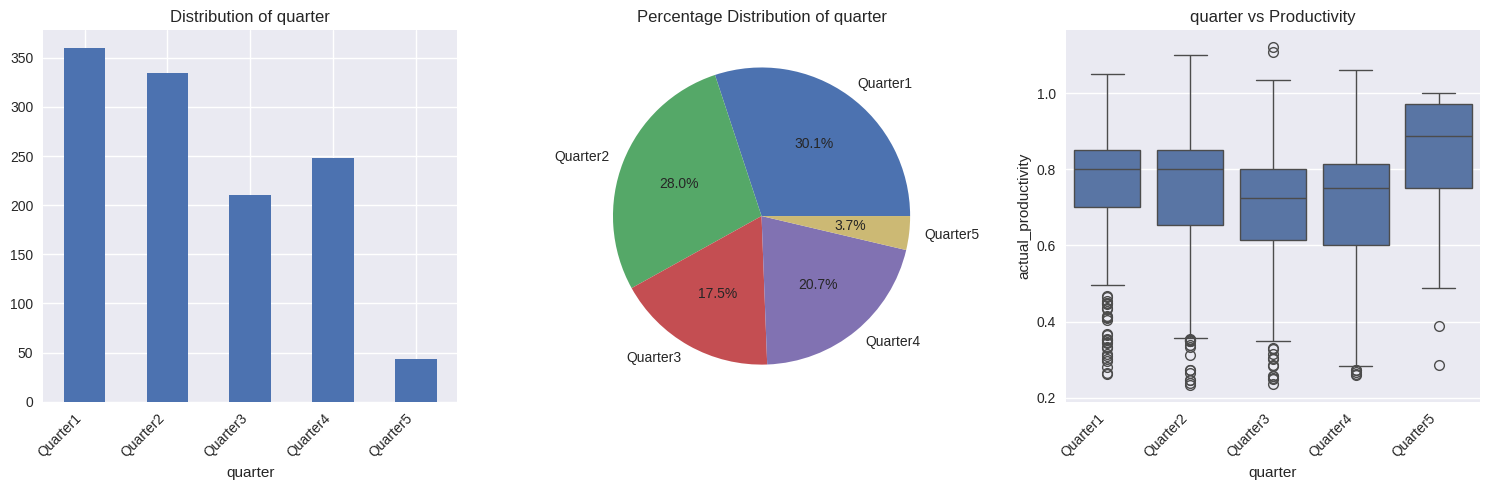

In [59]:
explore_categorical_feature(df, "quarter")

###department column

In [19]:
print(df[["wip", "department"]])

         wip  department
0     1108.0      sweing
1        NaN  finishing 
2      968.0      sweing
3      968.0      sweing
4     1170.0      sweing
...      ...         ...
1192     NaN   finishing
1193     NaN   finishing
1194     NaN   finishing
1195     NaN   finishing
1196     NaN   finishing

[1197 rows x 2 columns]


In [25]:
df[df["department"]== "finishing"]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
18,1/1/2015,Quarter1,finishing,Thursday,11,0.70,4.15,NaN,1440,0,0.0,0,0,12.0,0.436326
602,2/4/2015,Quarter1,finishing,Wednesday,2,0.80,3.94,NaN,2160,0,0.0,0,0,18.0,0.966759
603,2/4/2015,Quarter1,finishing,Wednesday,1,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.929183
604,2/4/2015,Quarter1,finishing,Wednesday,8,0.70,4.15,NaN,3000,0,0.0,0,0,25.0,0.915767
608,2/4/2015,Quarter1,finishing,Wednesday,7,0.70,3.94,NaN,960,0,0.0,0,0,8.0,0.779792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


looks like the "finishing" department is generating all the null values.

In [26]:
df["department"].value_counts()

,count
department,
sweing,691
finishing,257
finishing,249


We can see there is a problem with this column: we have two distinct "finishing" values.

In [27]:
df["department"].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

 We see that we have 'finishing ' (with a trailing space) and 'finishing' (without a space), so we will need to fix this problem later, during the Data Cleaning step.

###day column

day
Monday       199
Saturday     187
Sunday       203
Thursday     199
Tuesday      201
Wednesday    208
Name: count, dtype: int64


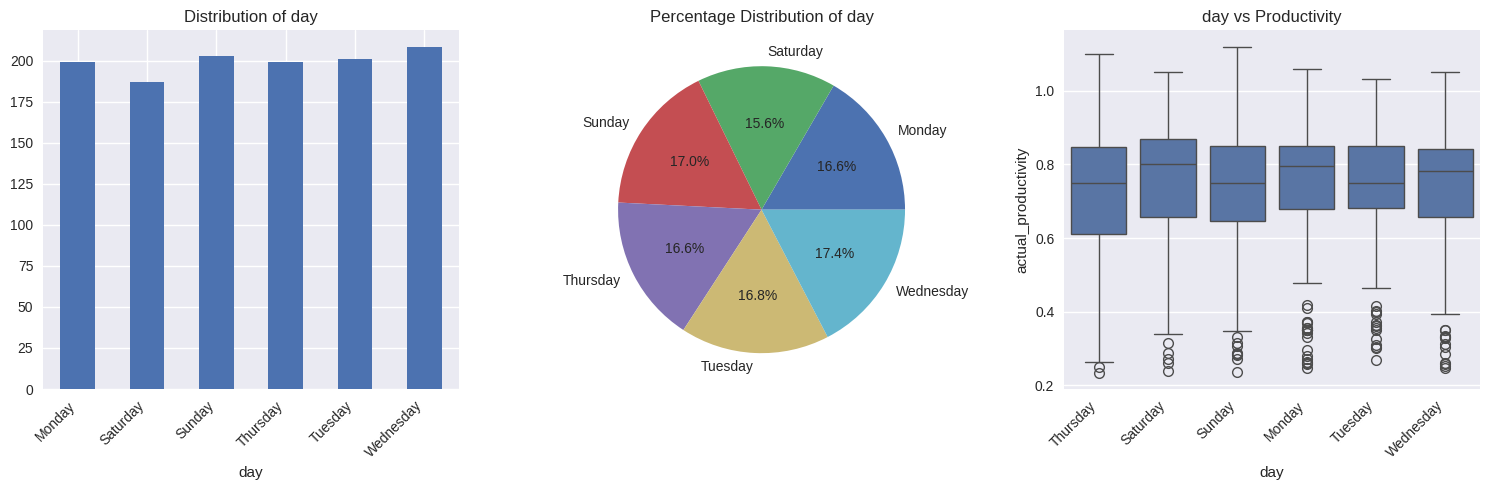

In [62]:
explore_categorical_feature(df, "day")

In [28]:
df["day"].value_counts()

,count
day,
Wednesday,208
Sunday,203
Tuesday,201
Thursday,199
Monday,199
Saturday,187


There is no friday, so I guess Friday is their off-day

###team column

team
1     105
2     109
3      95
4     105
5      93
6      94
7      96
8     109
9     104
10    100
11     88
12     99
Name: count, dtype: int64


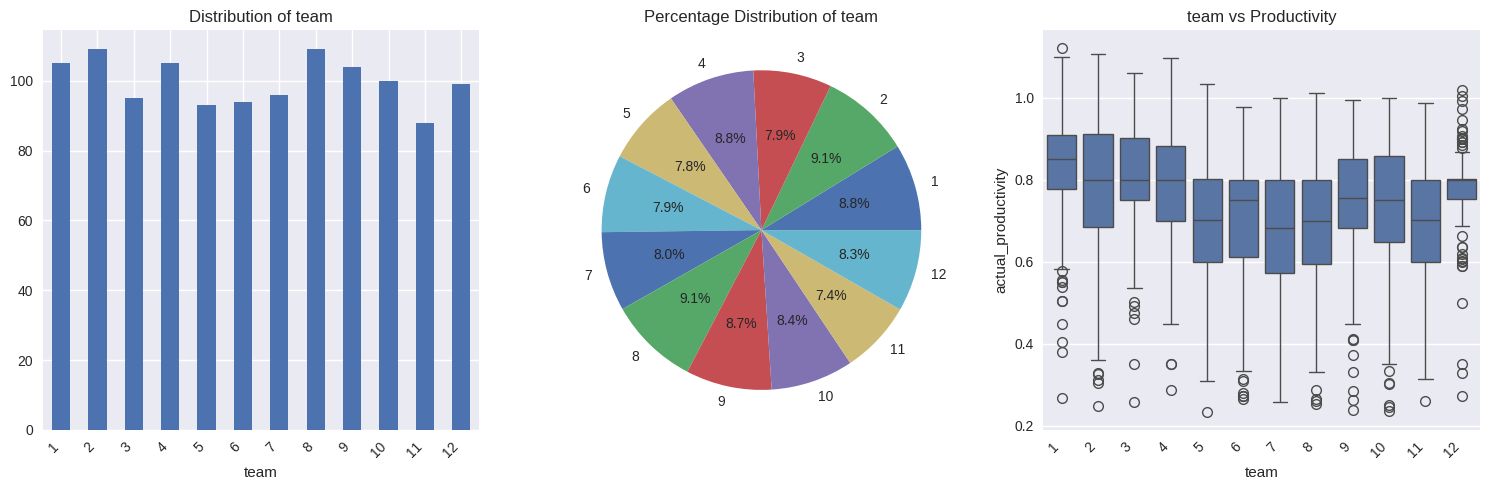

In [63]:
explore_categorical_feature(df, "team")

In [29]:
df["team"].value_counts().sort_index()

,count
team,
1,105
2,109
3,95
4,105
5,93
6,94
7,96
8,109
9,104


###"targeted_productivity" & "actual_productivity" columns
let's check the observations where the productivity was higher than expected.

targeted_productivity
0.07      1
0.35     27
0.40      2
0.50     49
0.60     57
0.65     63
0.70    242
0.75    216
0.80    540
Name: count, dtype: int64


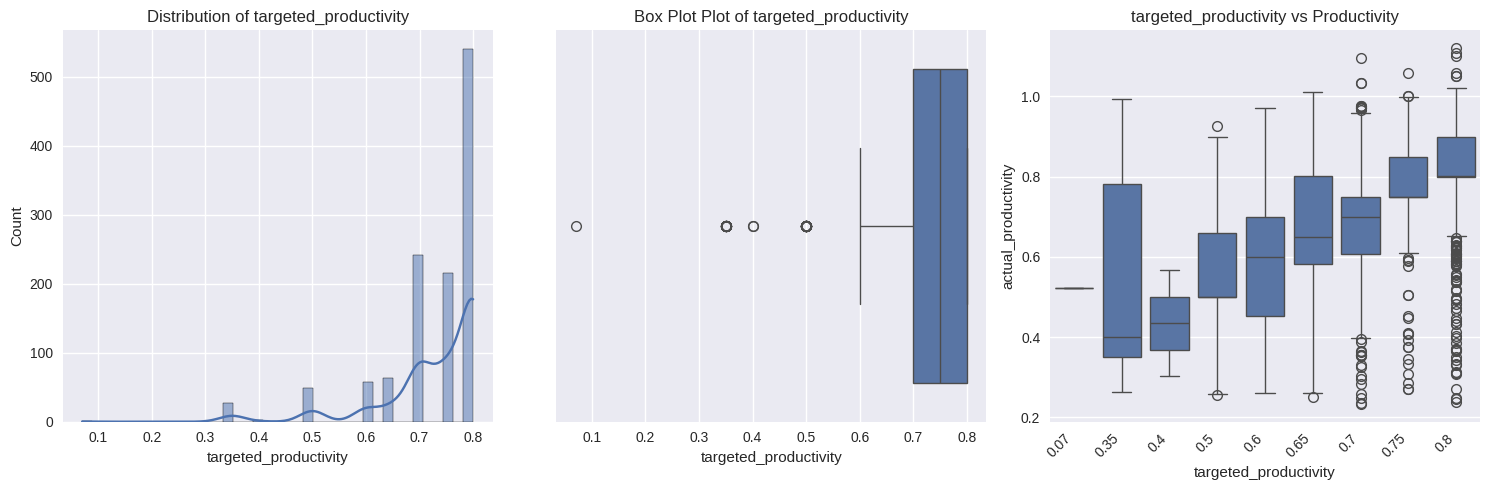

In [66]:
explore_numerical_feature(df, 'targeted_productivity')

In [30]:
df[df['actual_productivity'] > df['targeted_productivity']]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3/11/2015,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051
1188,3/11/2015,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,3/11/2015,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,3/11/2015,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


We can see that in ~75% of all observations, workers were productive and managed to surpass the target productivity threshold.

And now, what about the observations where the actual productivity was exactly equal to the target productivity?

In [32]:
df[df['actual_productivity'] == df['targeted_productivity']]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
163,1/10/2015,Quarter2,sweing,Saturday,10,0.8,28.08,1082.0,10530,63,0.0,0,0,58.5,0.8
182,1/11/2015,Quarter2,sweing,Sunday,2,0.8,28.08,805.0,10530,63,0.0,0,0,58.5,0.8
183,1/11/2015,Quarter2,sweing,Sunday,10,0.8,28.08,762.0,10530,38,0.0,0,0,58.5,0.8
207,1/12/2015,Quarter2,sweing,Monday,2,0.8,28.08,737.0,10530,63,0.0,0,0,58.5,0.8
229,1/13/2015,Quarter2,sweing,Tuesday,2,0.8,28.08,723.0,10530,50,0.0,0,0,58.5,0.8
855,2/19/2015,Quarter3,sweing,Thursday,8,0.7,29.40,1116.0,6240,0,0.0,0,2,57.0,0.7


In [33]:
df[df["targeted_productivity"] > df["actual_productivity"]]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
11,1/1/2015,Quarter1,sweing,Thursday,10,0.75,19.31,578.0,6480,45,0.0,0,0,54.0,0.712205
12,1/1/2015,Quarter1,sweing,Thursday,5,0.80,11.41,668.0,3660,50,0.0,0,0,30.5,0.707046
14,1/1/2015,Quarter1,finishing,Thursday,8,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.676667
15,1/1/2015,Quarter1,finishing,Thursday,4,0.75,3.94,NaN,2160,0,0.0,0,0,18.0,0.593056
16,1/1/2015,Quarter1,finishing,Thursday,7,0.80,2.90,NaN,960,0,0.0,0,0,8.0,0.540729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


Although far fewer than the number of productive days, there are still a lot of observations where productivity targets weren't met. Around ~25% of the total number of observations, actually.

And now, we should focus exclusively on the "actual_productivity" column to check all the observations where the range was higher than 1, despite the description indicating that 1 was the maximum possible value.

###over_time column

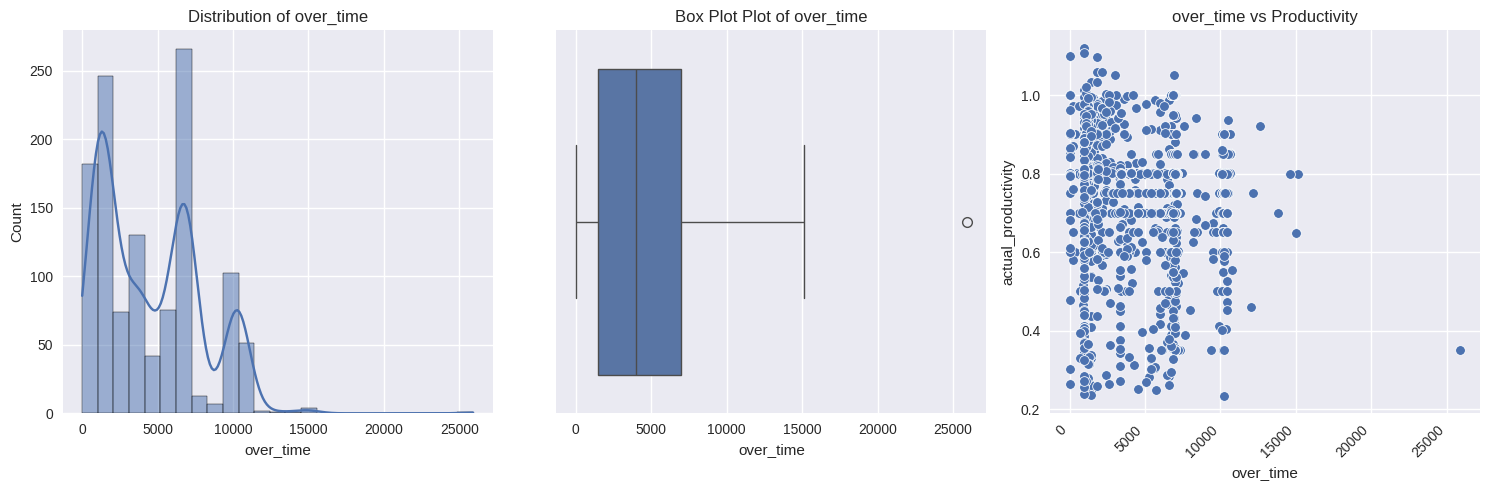

In [67]:
explore_numerical_feature(df, 'over_time')

In [34]:
df["over_time"].describe()

,over_time
count,1197.000000
mean,4567.460317
std,3348.823563
min,0.000000
25%,1440.000000
50%,3960.000000
75%,6960.000000
max,25920.000000


In [35]:
df[df["over_time"] > 3960]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683
8,1/1/2015,Quarter1,sweing,Thursday,2,0.75,19.87,733.0,6000,34,0.0,0,0,55.0,0.753098
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3/11/2015,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051
1188,3/11/2015,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,3/11/2015,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,3/11/2015,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


Almost half of the observations in the dataset feature a significant overtime among teams

In [37]:
len(df[df["over_time"] == 0])

31

We have only 31 total observations without overtime!
let's see how many observations surpassed the target productivity when overtime is 0

In [38]:
df[(df['over_time']==0) & (df['actual_productivity'] > df['targeted_productivity'])]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
684,2/9/2015,Quarter2,sweing,Monday,11,0.75,10.05,103.0,0,45,0.0,0,0,54.0,0.750648
694,2/10/2015,Quarter2,sweing,Tuesday,10,0.80,22.52,1268.0,0,88,0.0,0,0,56.0,0.900632
695,2/10/2015,Quarter2,sweing,Tuesday,1,0.80,22.52,1546.0,0,88,0.0,0,0,57.0,0.900471
696,2/10/2015,Quarter2,sweing,Tuesday,3,0.80,22.52,813.0,0,88,0.0,0,0,57.0,0.900471
697,2/10/2015,Quarter2,sweing,Tuesday,2,0.80,22.52,1512.0,0,88,0.0,0,0,57.0,0.899984
713,2/11/2015,Quarter2,sweing,Wednesday,2,0.80,22.52,1557.0,0,90,0.0,0,0,57.5,1.000345
714,2/11/2015,Quarter2,sweing,Wednesday,1,0.80,22.52,1498.0,0,113,0.0,0,0,57.0,1.000066
718,2/11/2015,Quarter2,sweing,Wednesday,10,0.80,22.52,598.0,0,75,0.0,0,0,56.0,0.850365
730,2/12/2015,Quarter2,sweing,Thursday,1,0.80,22.52,1397.0,0,138,0.0,0,0,57.0,1.100484
732,2/12/2015,Quarter2,sweing,Thursday,2,0.80,22.52,1327.0,0,113,0.0,0,0,57.5,1.000345


It's clear now that it's a rare event to meet targets without putting in overtime!

###"incentive" column
This column is about the financial incentives (in BDT) that motivate a particular course of action.

In [39]:
df["incentive"].describe()

,incentive
count,1197.000000
mean,38.210526
std,160.182643
min,0.000000
25%,0.000000
50%,0.000000
75%,50.000000
max,3600.000000


We can see that workers barely have incentives. How many observations don't feature any kind of incentive?

In [40]:
len(df[df['incentive']==0])

604

That's more than half of the entire dataset! let's see how many observations include incentives greater than 50

In [41]:
len(df[df["incentive"]>50])

231

In [42]:
len(df[df["incentive"] > 100])

34

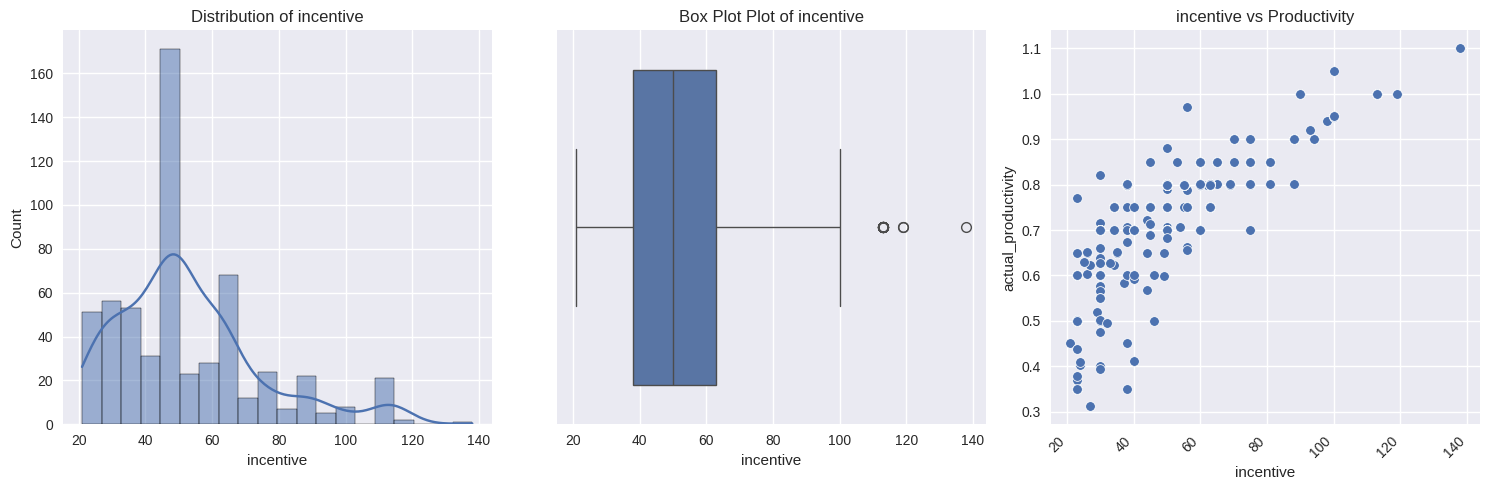

In [68]:
explore_numerical_feature(df[(df['incentive'] > 0) & (df['incentive'] < 200)], 'incentive')

In [69]:
corr = df['actual_productivity'].corr(df[(df['incentive'] > 0) & (df['incentive'] < 200)]['incentive'])
print(f"Correlation between 0 < 'incentive' < 200 and 'actual_productivity': {corr}")

Correlation between 0 < 'incentive' < 200 and 'actual_productivity': 0.8083750935775355


Here we can actually see a nice correlation, where the productivity tends to increase with the incentive, as long as the incentive isn't too high.

###"idle_time" & "idle_men" column

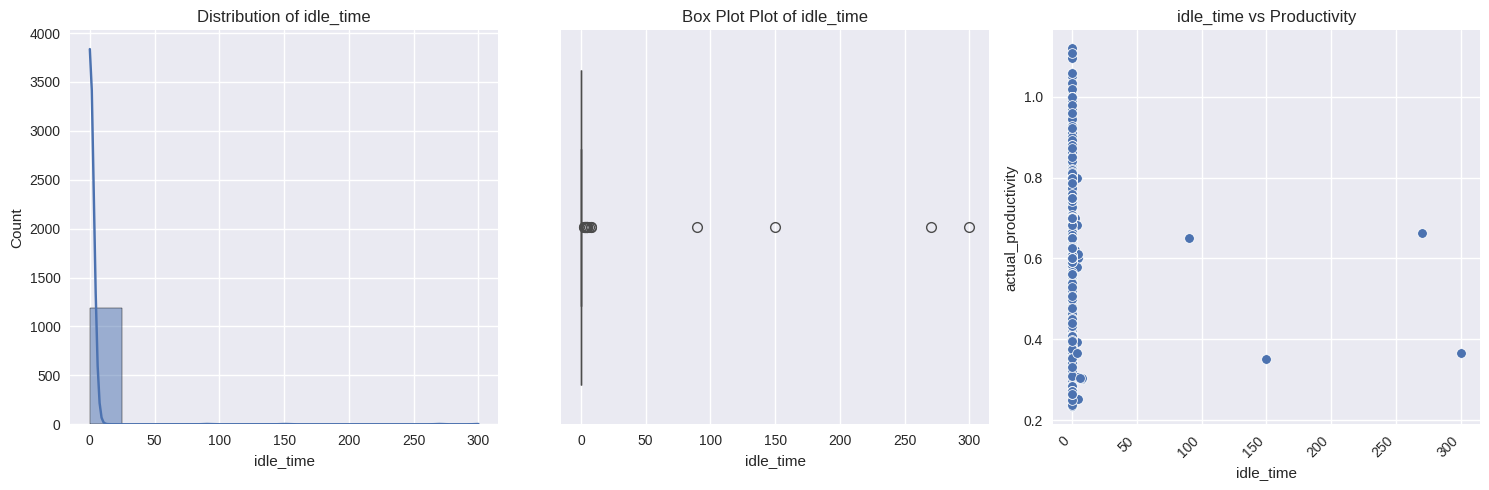

In [70]:
explore_numerical_feature(df, 'idle_time')

In [44]:
df[df["idle_time"] > 0]


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
615,2/4/2015,Quarter1,sweing,Wednesday,5,0.65,30.10,326.0,5820,0,90.0,10,0,58.5,0.650835
617,2/4/2015,Quarter1,sweing,Wednesday,4,0.35,30.10,287.0,6060,23,150.0,15,0,55.5,0.350706
650,2/7/2015,Quarter1,sweing,Saturday,7,0.70,24.26,658.0,6960,0,270.0,45,0,58.0,0.662270
654,2/7/2015,Quarter1,sweing,Saturday,8,0.70,24.26,652.0,6840,0,300.0,37,0,57.0,0.365319
775,2/15/2015,Quarter3,sweing,Sunday,8,0.70,30.10,507.0,5880,40,2.0,10,1,59.0,0.700573
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983
822,2/17/2015,Quarter3,sweing,Tuesday,10,0.65,18.22,741.0,0,0,8.0,35,1,49.0,0.302117
841,2/18/2015,Quarter3,sweing,Wednesday,10,0.70,19.68,1119.0,5640,0,8.0,35,1,47.0,0.303574
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399


In [45]:
len(df[(df["idle_time"] > 0)])

18

We see that the factory rarely suffers from interruptions, with only 18 observations where something like this happened.

idle_men
0     1179
10       3
15       3
20       3
25       1
30       3
35       2
37       1
40       1
45       1
Name: count, dtype: int64


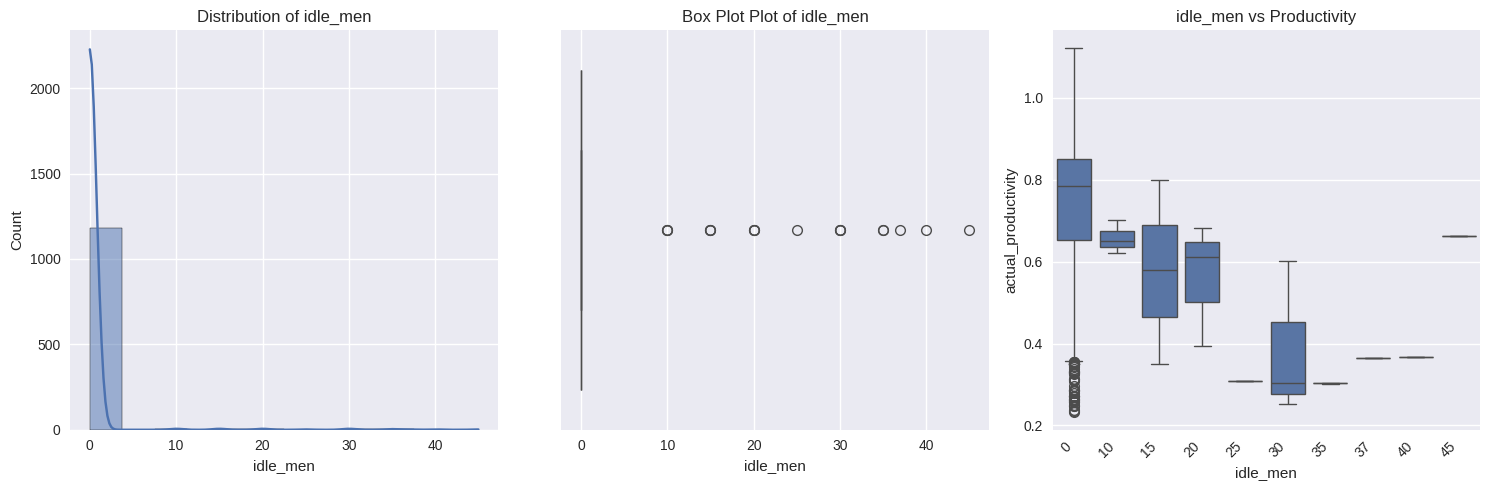

In [71]:
explore_numerical_feature(df, 'idle_men')

In [46]:
len(df[(df["idle_men"] > 0)])

18

###"no_of_style_change" Column
number of changes in the style of a particular product

no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64


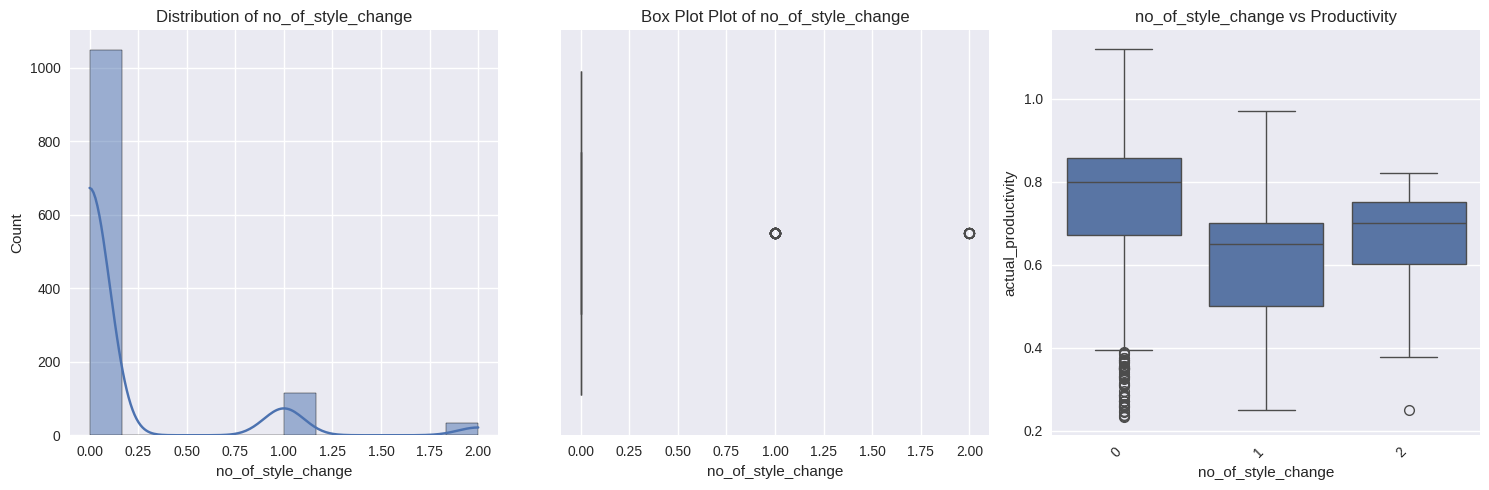

In [72]:
explore_numerical_feature(df, 'no_of_style_change')

In [47]:

df["no_of_style_change"].describe()

,no_of_style_change
count,1197.000000
mean,0.150376
std,0.427848
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


Since the number of changes in the style of a particular product was pretty much 0 in most cases, it would be nice to have an idea of how many observations did feature these changes

In [48]:
df[df["no_of_style_change"] == 1]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
634,2/5/2015,Quarter1,sweing,Thursday,4,0.50,30.10,417.0,6360,23,0.0,0,1,53.0,0.500720
651,2/7/2015,Quarter1,sweing,Saturday,4,0.60,30.10,486.0,6780,30,0.0,0,1,57.0,0.600224
671,2/8/2015,Quarter2,sweing,Sunday,4,0.65,30.10,712.0,6780,44,0.0,0,1,56.5,0.568260
683,2/9/2015,Quarter2,sweing,Monday,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,0.790003
689,2/9/2015,Quarter2,sweing,Monday,7,0.35,30.10,842.0,6960,0,0.0,0,1,58.0,0.350302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,3/11/2015,Quarter2,sweing,Wednesday,2,0.75,16.10,971.0,5400,45,0.0,0,1,45.0,0.750141
1188,3/11/2015,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,3/11/2015,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,3/11/2015,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


In [51]:
df[df["no_of_style_change"] == 2]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
744,2/12/2015,Quarter2,sweing,Thursday,11,0.50,11.41,1039.0,2280,0,0.0,0,2,55.0,0.500123
761,2/14/2015,Quarter2,sweing,Saturday,11,0.60,11.41,1039.0,2280,23,0.0,0,2,55.0,0.600448
777,2/15/2015,Quarter3,sweing,Sunday,11,0.65,11.41,700.0,2640,23,0.0,0,2,53.0,0.650224
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972
799,2/16/2015,Quarter3,sweing,Monday,11,0.70,11.41,680.0,2160,30,0.0,0,2,54.0,0.565972
813,2/17/2015,Quarter3,sweing,Tuesday,11,0.70,11.41,1054.0,3420,30,0.0,0,2,56.0,0.700614
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983
826,2/18/2015,Quarter3,sweing,Wednesday,11,0.70,11.41,685.0,3360,30,0.0,0,2,56.0,0.821113
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399
854,2/19/2015,Quarter3,sweing,Thursday,11,0.70,11.41,653.0,3480,30,0.0,0,2,58.0,0.700540


In [50]:
len(df[df["no_of_style_change"] == 2])

33

Only 33 observations in the whole dataset included two changes of style.

###"no_of_workers" column
For this column, an interesting option could be to explore different observations that surpass a certain number of workers in each team. An alternative could be to inspect the observations where teams are very small.

Let's use the 75% percentile (57) as a threshold.

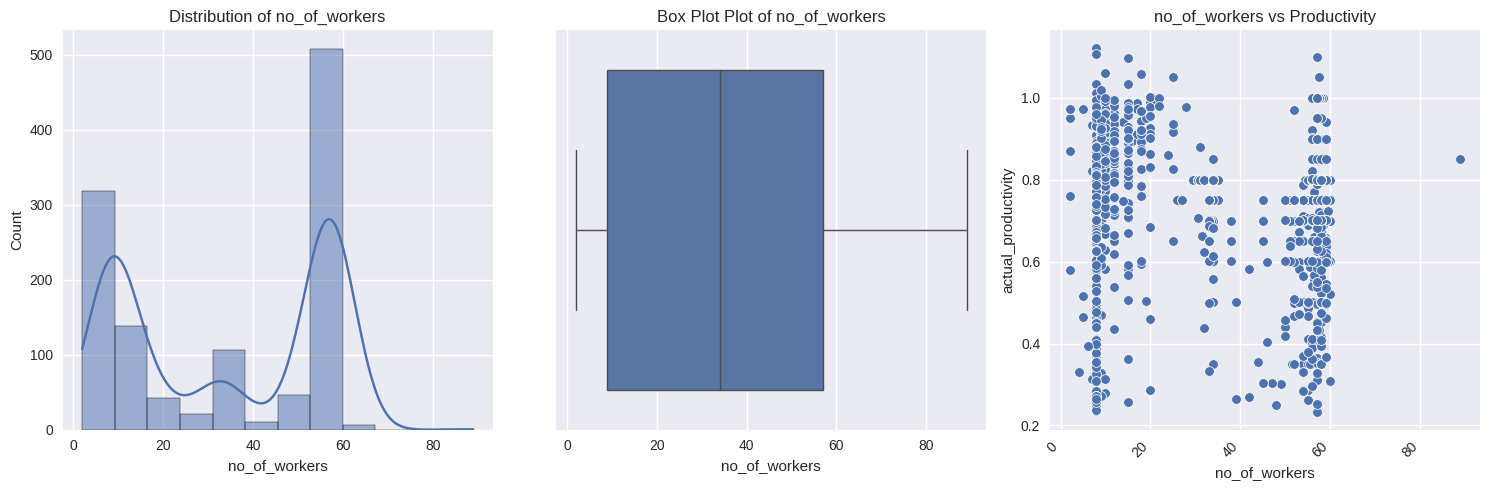

In [73]:
explore_numerical_feature(df, 'no_of_workers')

In [52]:
df[df["no_of_workers"] > 57]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428
10,1/1/2015,Quarter1,sweing,Thursday,9,0.70,28.08,872.0,6900,44,0.0,0,0,57.5,0.721127
17,1/1/2015,Quarter1,sweing,Thursday,4,0.65,23.69,861.0,7200,0,0.0,0,0,60.0,0.521180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,3/11/2015,Quarter2,sweing,Wednesday,3,0.80,30.10,735.0,6960,63,0.0,0,1,58.0,0.800072
1180,3/11/2015,Quarter2,sweing,Wednesday,11,0.80,11.41,560.0,3420,50,0.0,0,0,58.0,0.800035
1186,3/11/2015,Quarter2,sweing,Wednesday,1,0.75,26.82,1322.0,7080,45,0.0,0,0,59.0,0.750051
1187,3/11/2015,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051


##**Dataset Properties:**


*   The dataset has 1,197 observations and 15 features
*   The wip(Work In Progress) feature has 506 missing values(department = finishing)


*   The maximum wip (Work in Progress) value is 23122. This means there is an observation where the number of unfinished items for products is 23122!




*   The dataset has 4 object data types and rest of them are either integer or float.
*   The date d-type is object(Have to convert it to datetime for the analysis)



*   Interestingly the Quarter column is referring to part of a month instead of an year
*   We can conclude that time management in this factory is pretty efficient as there is no values for idle_time and idle_men.



*   In department column we see that we have 'finishing ' (with a trailing space) and 'finishing' (without a space), so we will need to fix this problem later, during the Data Cleaning step.
*   Factory is closed on fridays


*   ~75% of all observations, workers were productive and managed to surpass the target productivity threshold.
*   ~25% of all obseravations, workers failed to surpass the target productivity threshold

*   After analyzing overtime column found out, it's a rare event to meet targets without putting in overtime!
*   604 workers don't get incentives

*   Only 231 workers get incentives more than 50 BDT and 34 workers get incentives more than 100 BDT
*   Only 18 observations get idle time











##**Data Cleaning(1)**
After properly exploring all the columns, we're now finally able to start cleaning and preparing the data for our Decision Tree model!

Let's start with the "department" column where we found a trailing space that generated two different "finishing" values.

In [54]:
#unique values in department column
df["department"].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

In [56]:
df.loc[df['department'] == "finishing ", "department"] = "finishing"
df["department"].value_counts()

,count
department,
sweing,691
finishing,506


department
finishing    506
sweing       691
Name: count, dtype: int64


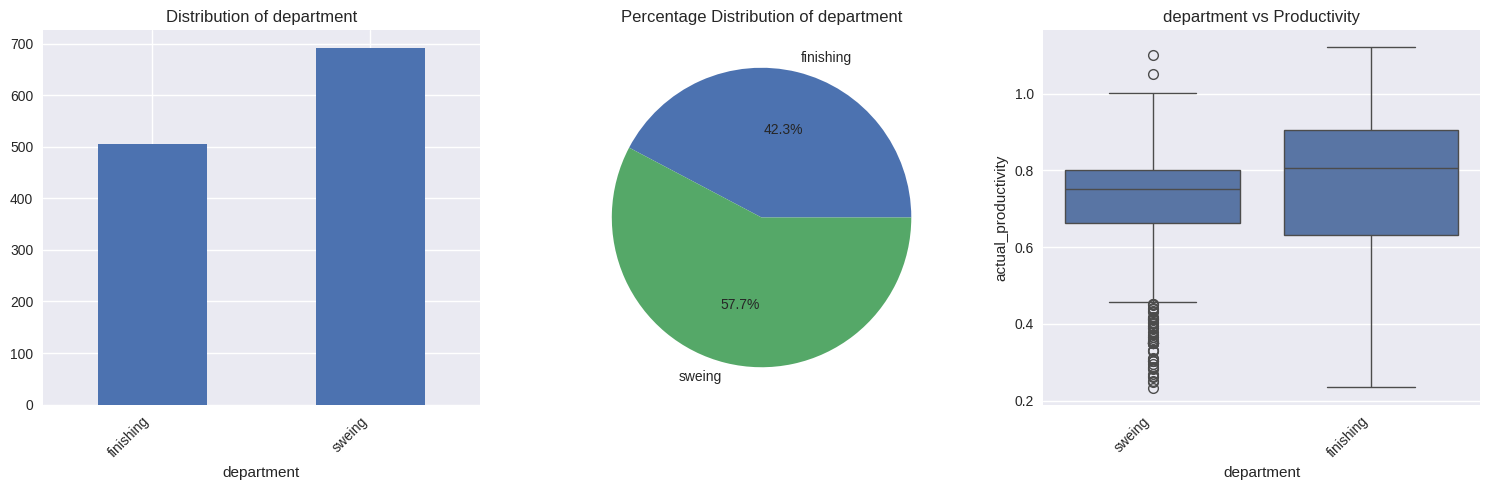

In [74]:
explore_categorical_feature(df, "department")

###Date
The date column needs to be converted into DataTime:

In [75]:
df['date'] = pd.to_datetime(df['date'])

In [76]:
corr = df['actual_productivity'].corr(df['date'])
print(f"Correlation between 'date' and 'actual_productivity': {corr}")

Correlation between 'date' and 'actual_productivity': -0.12257480040343238


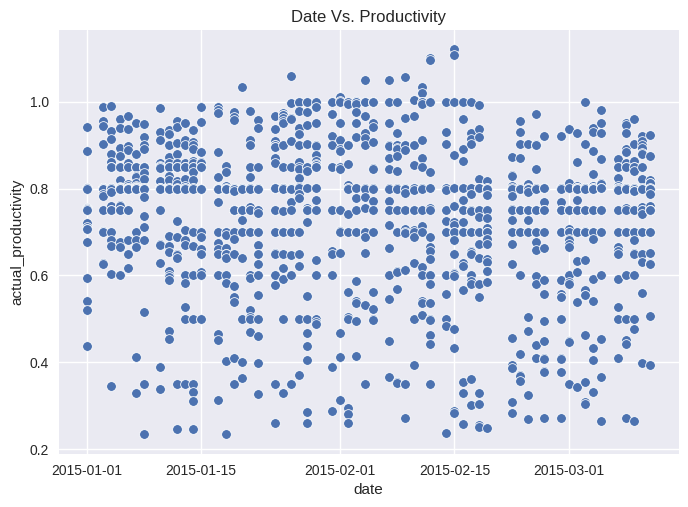

In [78]:
sns.scatterplot(x='date', y='actual_productivity', data=df)
plt.title("Date Vs. Productivity")
plt.show()

It's quite clear from the scatter plot and the correlation value that the date has no predictive power when it comes to actual_productivity, so it's safe to remove it from the dataset.

In [83]:
df.columns

Index(['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv',
       'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity'],
      dtype='object')

###quarter column
To make analysis easier I'll convert the value in this column into int:

In [84]:
df = df.replace({'quarter':{'Quarter1': 1,
                     'Quarter2': 2,
                     'Quarter3': 3,
                     'Quarter4': 4,
                     'Quarter5': 5}})

In [85]:
df['quarter'].value_counts()

,count
quarter,
1,360
2,335
4,248
3,210
5,44


###wip column

The WiP column holds the number of unfinished items, so it should be an int rather than float:

In [88]:
df['wip'] = df['wip'].astype('Int64')

###No. of Workers
Likewise no_of_workers column needs to be converted to an int

In [90]:
df['no_of_workers'] = df['no_of_workers'].round().astype('Int64')

###idle_time, idle_men and no_of_style_change
Based on the result of the previous section, they don't have enough distinct values to make a meaningful prediction.
So i have decided to drop them

In [91]:
df.drop(['idle_time', 'idle_men', 'no_of_style_change'], axis=1, inplace=True)
df.columns

Index(['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv',
       'wip', 'over_time', 'incentive', 'no_of_workers',
       'actual_productivity'],
      dtype='object')

##**Selected Features**


*   **quarter** (a portion of the month — month was divided into four quarters)

*   **department** (associated department with the instance)

*   **day** (day of the week)

*   **team** (associated team number with the instance)

*   **targeted_productivity** (targeted productivity set by the authority for each team for each day)

*   **smv** (standard minute value — the allocated time for a task)
*   **wip** (work in progress — includes the number of unfinished items for products)


*   **over_time** (represents the amount of overtime by each team in minutes)


*   **incentive** (represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action)


*   **no_of_workers** (number of workers on each team)


*   **actual_productivity** (the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.)






###**Creating a Target Column**
Since this is project deals with a classification tree, I can't use the actual_productivity column as my target column, since the target needs to be categorical. What I can do is create a new boolean column that checks if the workers have reached their targeted productivity, by comparing actual_productivity and targeted_productivity:

In [92]:
df['productive'] = df['actual_productivity'] >= df['targeted_productivity']
# Now it's safe to drop the 'actual_productivity' column, since it's no longer needed
df = df.drop('actual_productivity', axis=1)

In [93]:
df['productive'].value_counts()

,count
productive,
True,875
False,322


###**Categorical to Numerical**
Since scikit-learn only works with numerical data, I need to convert some columns from categorical to numerical to use them in the model.

In [94]:
categorical_cols = ['quarter', 'department', 'day', 'team']

In [95]:
# Getting the dummies and removing the categorical columns. setting drop_first to True, to reduce the number of features
data_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [96]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   targeted_productivity  1197 non-null   float64
 1   smv                    1197 non-null   float64
 2   wip                    691 non-null    Int64  
 3   over_time              1197 non-null   int64  
 4   incentive              1197 non-null   int64  
 5   no_of_workers          1197 non-null   Int64  
 6   productive             1197 non-null   bool   
 7   quarter_2              1197 non-null   bool   
 8   quarter_3              1197 non-null   bool   
 9   quarter_4              1197 non-null   bool   
 10  quarter_5              1197 non-null   bool   
 11  department_sweing      1197 non-null   bool   
 12  day_Saturday           1197 non-null   bool   
 13  day_Sunday             1197 non-null   bool   
 14  day_Thursday           1197 non-null   bool   
 15  day_

##**Building the Tree**
I'm now ready to build the decision tree:

In [97]:
# Create the feature and target columns

X = data_dummies.drop("productive", axis = 1)
y = data_dummies["productive"]

# Divide in training and test sets with train_test_split. Setting random_state to 755 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 755)

# Instantiate and fit a decision tree classifier. Setting max_depth to 4, to reduce complexity and random_state to 755 for reproducibility
tree = DecisionTreeClassifier(max_depth=4, random_state = 755)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=755)

In [98]:
# Use the tree to make the predictions on the test set
y_pred = tree.predict(X_test)

##**Visualizing and Evaluating the Tree**

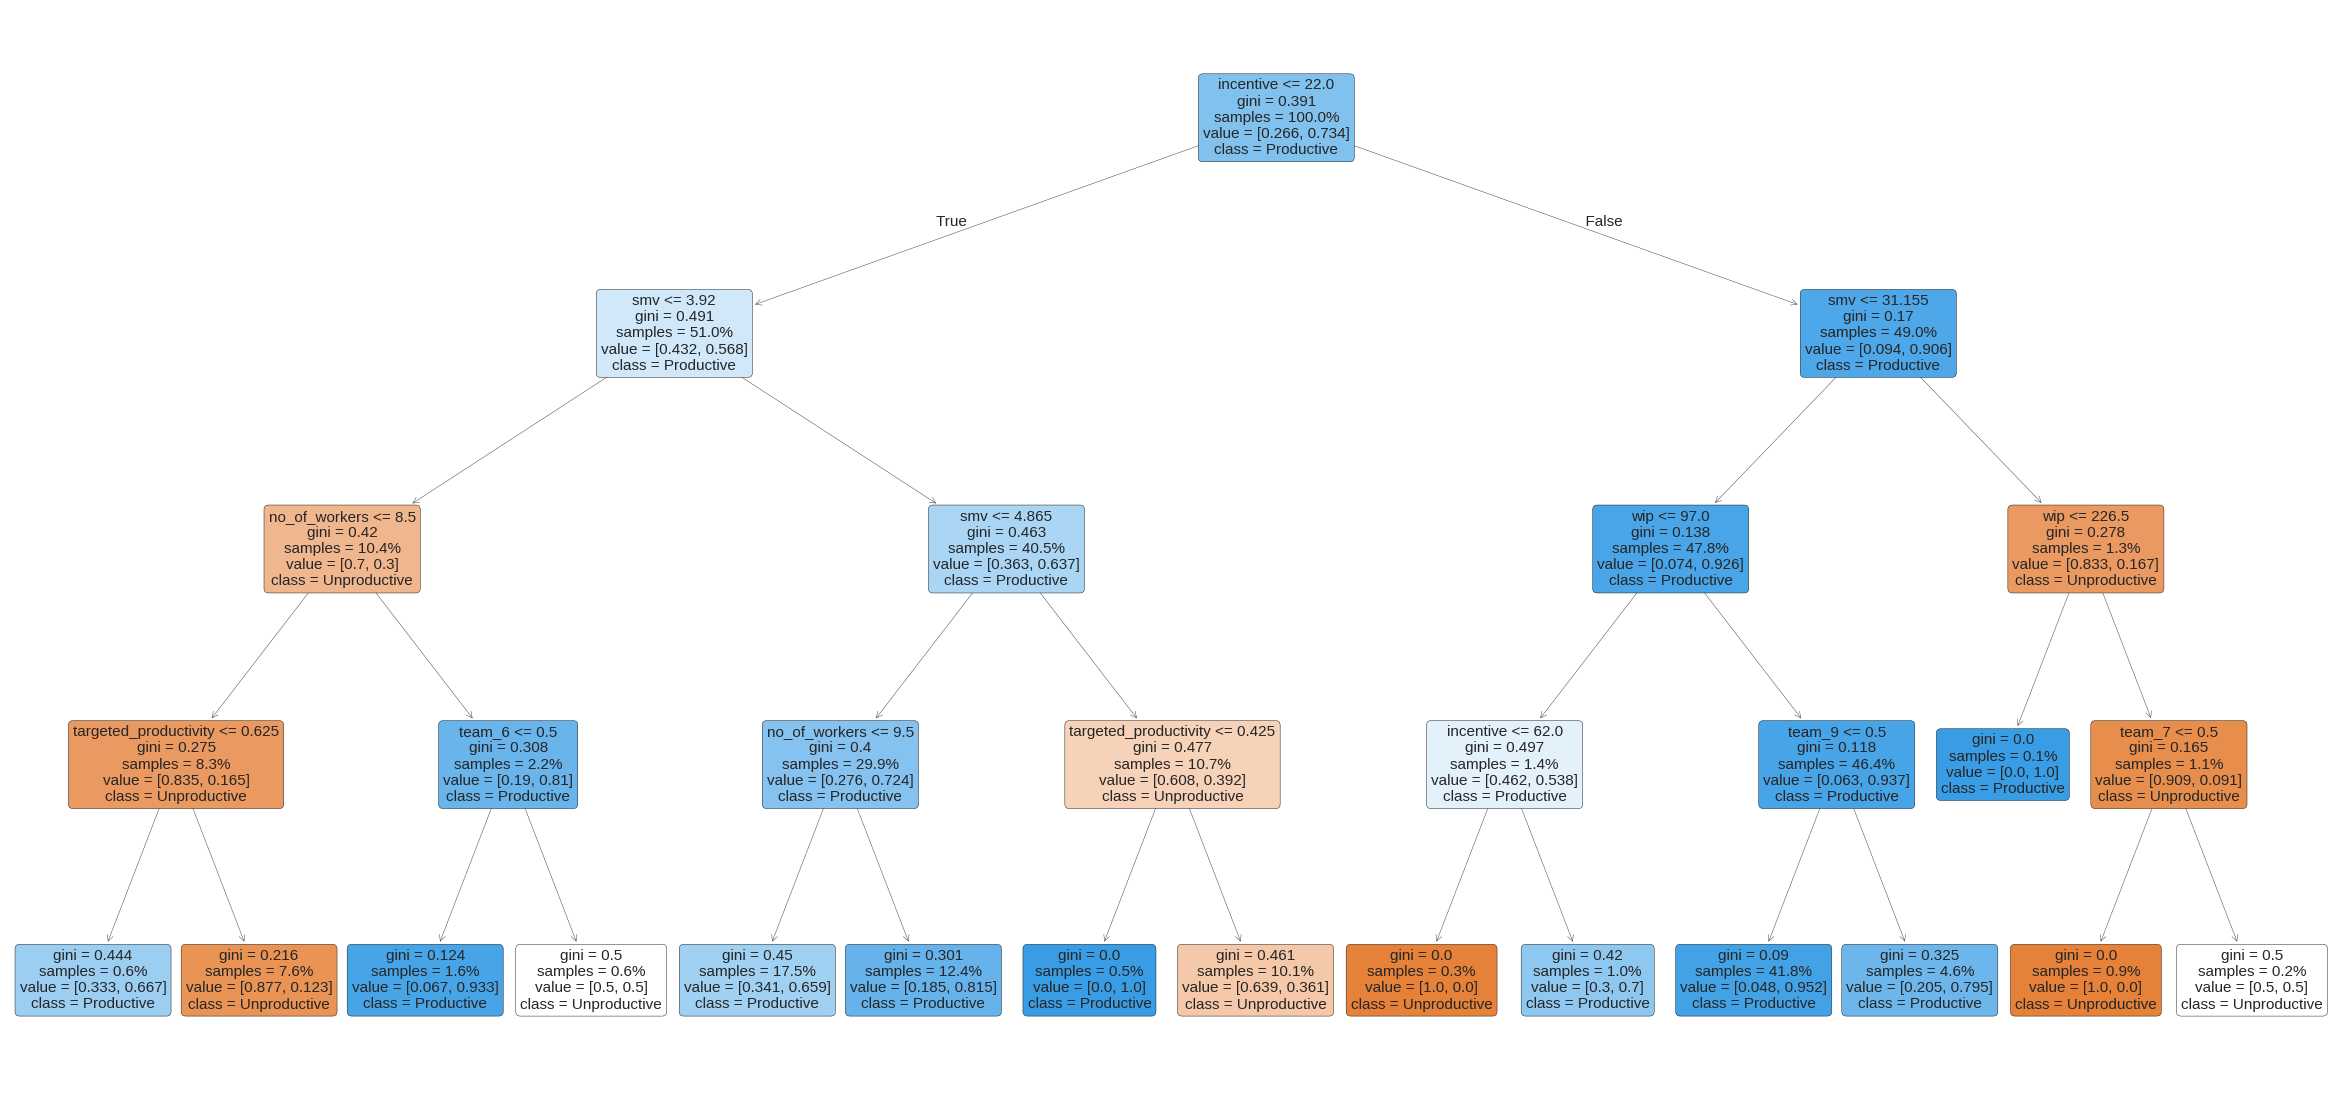

In [99]:
# Setting plot size
plt.figure(figsize = [30, 14])

# Plotting the tree with some specific parameters:
# class_names: Using 'Unproductive' and 'Productive' instead of False and True
# filled: Show color-coded nodes
# rounded: Use rounded corners
# proportion: Display number of samples and values as a proportion of the dataset's size
_ = plot_tree(tree,
              feature_names = X.columns,
              class_names = ["Unproductive", "Productive"],
              filled = True,
              rounded = True,
              proportion = True,
              fontsize = 11)

In [100]:
def evaluate_model(y_true, y_pred, y_prob):
    """
    Comprehensive model evaluation function

    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    y_prob: Predicted probabilities
    """
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 2. Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Unproductive', 'Productive'], text_kw={'fontsize': 12})
    plt.title('Confusion Matrix for the Tree Classification Model', fontsize = 14, pad=20)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 3. Detailed Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # 4. Additional Performance Metrics
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    print("\nDetailed Performance Metrics:")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"\nSensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

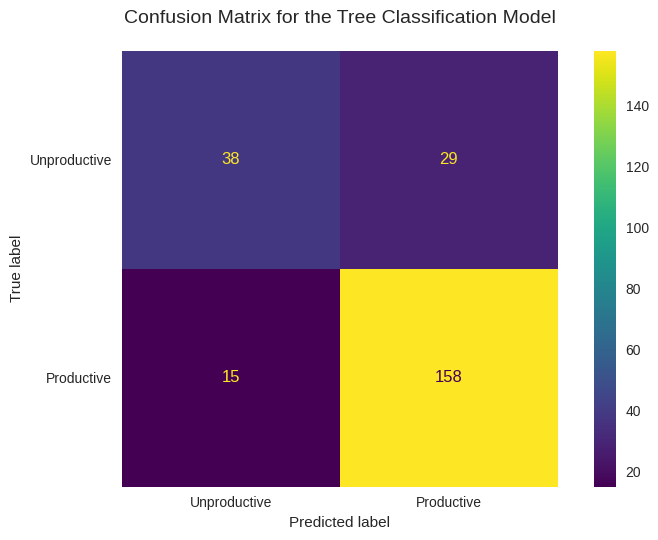

Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.57      0.63        67
        True       0.84      0.91      0.88       173

    accuracy                           0.82       240
   macro avg       0.78      0.74      0.76       240
weighted avg       0.81      0.82      0.81       240


Detailed Performance Metrics:
True Positives (TP): 158
True Negatives (TN): 38
False Positives (FP): 29
False Negatives (FN): 15

Sensitivity (Recall): 0.9133
Specificity: 0.5672
Precision: 0.8449
F1 Score: 0.8778


In [101]:
y_test_prob = tree.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_test_prob)

The classification tree performs well overall in forecasting employee productivity, achieving an accuracy of 81% on the dataset. It excels at detecting high-productivity cases (True class), with a precision of 0.85 and an outstanding recall of 0.9, meaning it accurately identifies 90% of actual high-productivity instances while minimizing false positives.

However, its ability to predict low productivity (False class) is less reliable, with precision and recall dropping to 0.70 and 0.58, respectively. The specificity of 0.58 further highlights the model’s difficulty in correctly classifying low-productivity cases, leading to frequent misclassifications. This disparity in performance between the two classes may stem from the uneven distribution of data (173 True vs. 67 False instances) or the inherent complexity of features linked to low productivity.

Additionally, the most influential predictors in the model are incentive and smv.

It also shows that the features with the highest predictive power are incentive and smv.

##**Explaining the Tree**

Decision trees provide a visual representation of how a machine learning model arrives at its conclusions. They begin with a general question at the root and progressively split into more detailed questions, resembling the branches of a tree. Each split is called a "node," while the end results are referred to as "leaves."

In this scenario, the decision tree predicts whether a team is "Productive" or "Unproductive" by analyzing different work-related factors. The first node checks if the team's incentive exceeds 22. If it does, the model then evaluates the SMV (Standard Minute Value) against 31.155. If the incentive is under 0.4, it compares the SMV to 3.92, and so on.

The tree continues dividing based on criteria such as overtime and targeted productivity until it reaches a final classification (leaf node), assigning each employee to either "Productive" or "Unproductive." By tracing these branches, you can understand the model's decision-making process.

##**Using Random Forest**

Now that we have a baseline tree, we can use the Random Forest method to try and improve the tree's accuracy.

In [102]:
# Create a Random Forest Classifier model, setting random_state to ensure reproducibility
# Setting oob_score to True provides an unbiased estimate of the model's generalization error
forest = RandomForestClassifier(
                                oob_score = True,
                                random_state = 10
                               )

forest.fit(X_train, y_train)


RandomForestClassifier(oob_score=True, random_state=10)

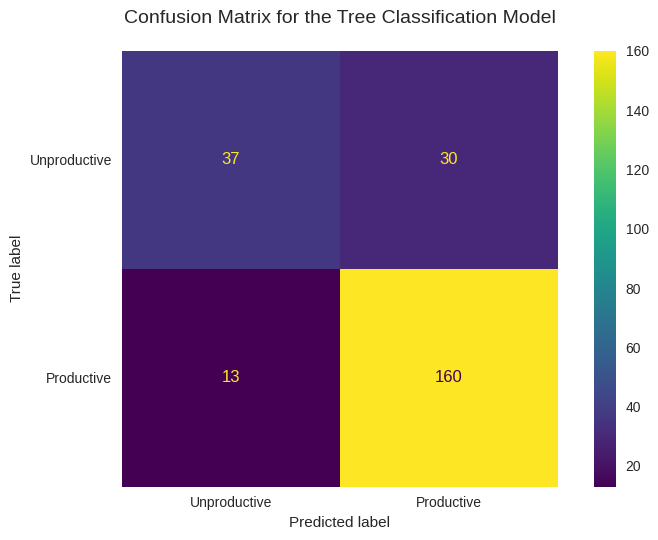

Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.55      0.63        67
        True       0.84      0.92      0.88       173

    accuracy                           0.82       240
   macro avg       0.79      0.74      0.76       240
weighted avg       0.81      0.82      0.81       240


Detailed Performance Metrics:
True Positives (TP): 160
True Negatives (TN): 37
False Positives (FP): 30
False Negatives (FN): 13

Sensitivity (Recall): 0.9249
Specificity: 0.5522
Precision: 0.8421
F1 Score: 0.8815


In [103]:
y_pred_forest = forest.predict(X_test)
y_test_prob_forest = forest.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_forest, y_test_prob_forest)

Using Random Forest performs didn't improve the model, and left all metrics pretty much as they were.

I can try improving the model by using hyperparameter optimisation:

##**Hyperparameter Tuning**

In [104]:
def tune_random_forest(X, y, forest):
    """
    Perform hyperparameter tuning for a Decision Tree Classifier
    with a focus on improving specificity

    Parameters:
    X : feature matrix
    y : target variable

    Returns:
    The grid_search object
    """
    param_grid = {
        # Adjust max_depth to control overfitting and tree complexity
        'max_depth': [3, 4, 5, 7, 10],

        # Modify min_samples_split to control tree growth
        'min_samples_split': [2, 5, 10, 15],

        # Adjust min_samples_leaf to reduce overfitting
        'min_samples_leaf': [1, 2, 4, 6],

        # Control class imbalance
        'class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}]
    }

    # Use StratifiedKFold to maintain class distribution
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    grid_search = GridSearchCV(
        estimator=forest,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        verbose=2,
        n_jobs=-1  # Use all available cores
    )

    grid_search.fit(X, y)

    return grid_search

In [105]:
grid_search = tune_random_forest(X, y, forest)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [107]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best params: {best_params}")

Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


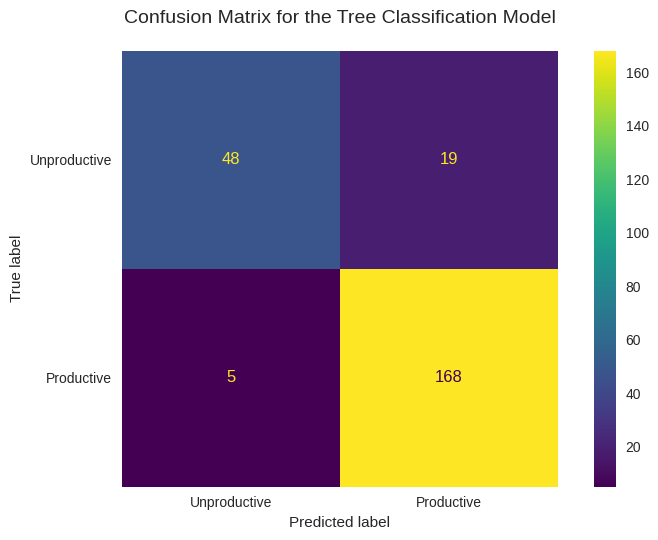

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.72      0.80        67
        True       0.90      0.97      0.93       173

    accuracy                           0.90       240
   macro avg       0.90      0.84      0.87       240
weighted avg       0.90      0.90      0.90       240


Detailed Performance Metrics:
True Positives (TP): 168
True Negatives (TN): 48
False Positives (FP): 19
False Negatives (FN): 5

Sensitivity (Recall): 0.9711
Specificity: 0.7164
Precision: 0.8984
F1 Score: 0.9333


In [108]:
y_pred = grid_search.predict(X_test)
y_test_prob = grid_search.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_test_prob)

**Using hyperparameter optimisation of the random forest I managed to improve every metric significantly**



*   accuracy: **90%** vs. **82%**

*   sensitivity: **97%** vs. **93%**

*   precision: **90%** vs. **84%**
*   F1 score: **93%** vs. **88%**


*   specificity: **71%** vs. **55%**






#**Conclusion**

For this project, I developed machine learning models to predict employee productivity using Decision Tree and Random Forest classifiers, enhanced through hyperparameter optimization. The models analyzed key parameters including incentive levels, work-in-progress status, and Standard Minute Value (SMV).

**The final optimized model achieved:**


*   **90%** overall accuracy on test data

*   Exceptional **97%** sensitivity (correctly identifying productive employees)
*   Moderate **71%** specificity (identifying unproductive cases)









